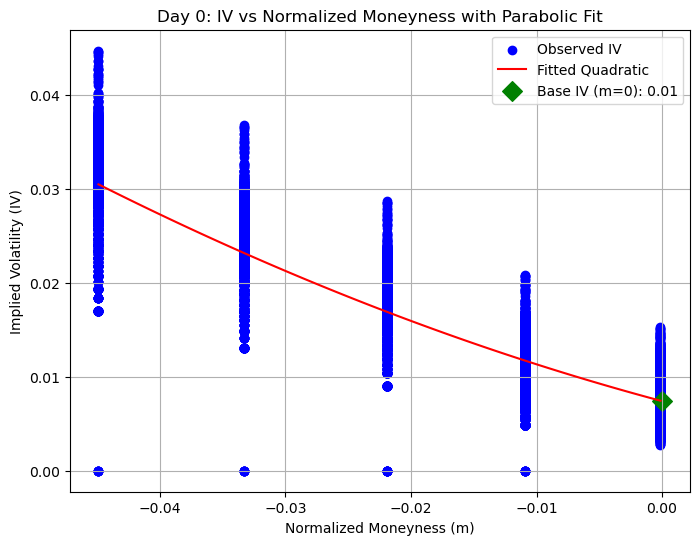

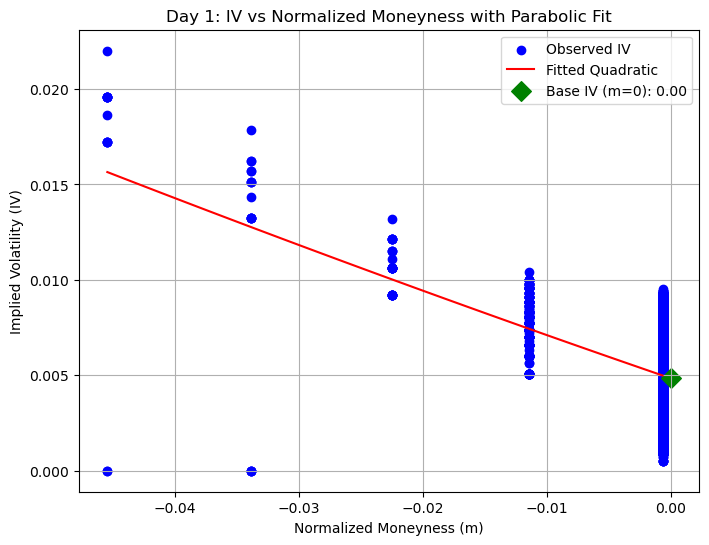

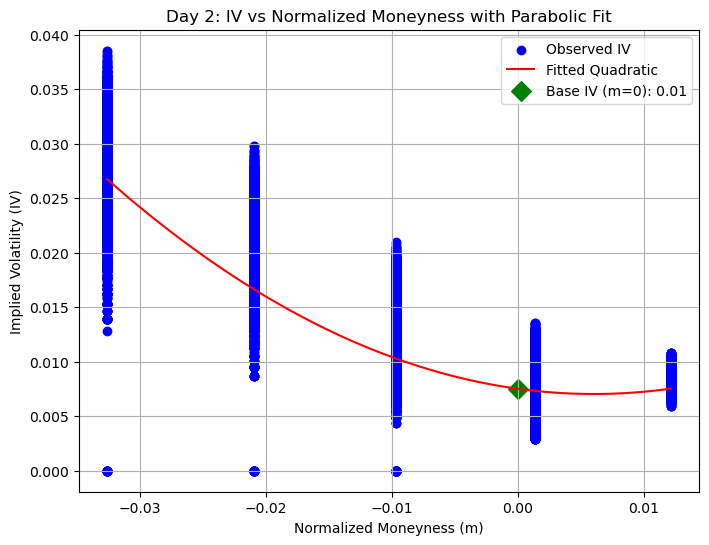

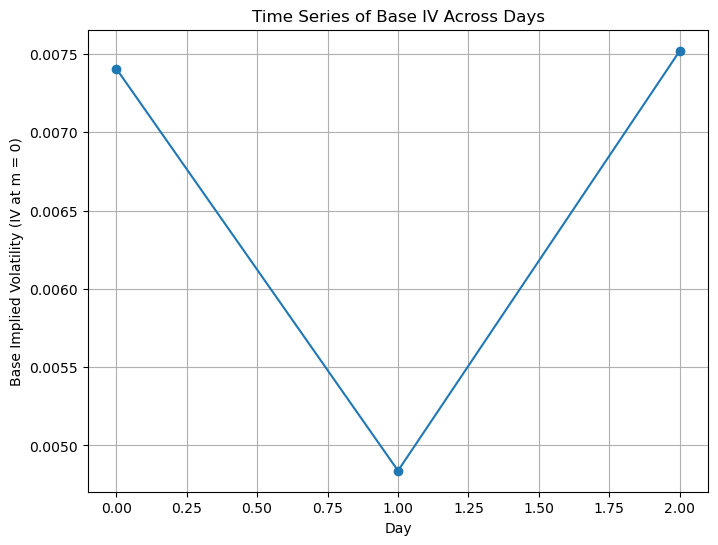

In [6]:
import pandas as pd
import numpy as np
import math
from scipy import stats, optimize
import matplotlib.pyplot as plt

# === Utility Functions ===

# Black-Scholes call price (assumes zero risk-free rate)
def bs_call_price(S, K, T, sigma, r=0.0):
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

# Implied volatility finder using Brent's method.
def implied_vol(S, K, T, market_price, r=0.0):
    def f(sigma):
        return bs_call_price(S, K, T, sigma, r) - market_price
    try:
        vol = optimize.brentq(f, 1e-6, 5.0)
    except Exception:
        vol = np.nan
    return vol

# Black-Scholes vega (sensitivity of option price to volatility)
def bs_vega(S, K, T, sigma, r=0.0):
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return S * np.sqrt(T) * stats.norm.pdf(d1)

# === Load Data ===

# List the CSV filenames (ensure paths are correct)
files = [
    "prices_round_3_day_0.csv",
    "prices_round_3_day_1.csv",
    "prices_round_3_day_2.csv"
]

# Load CSV files (using ';' as delimiter) and add a "day" indicator.
dfs = []
for i, file in enumerate(files):
    df = pd.read_csv("" + file, delimiter=';')
    df["day"] = i  # Tag each file with the corresponding day number.
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

# --- Extract Underlying Price ---

# Rows where product == "VOLCANIC_ROCK" contain the underlying price.
# We use the mid_price column as S.
underlying_df = data[data["product"] == "VOLCANIC_ROCK"][["day", "mid_price"]].rename(columns={"mid_price": "S"})

# If there are multiple underlying rows per day, take one (e.g., the first occurrence).
underlying_df = underlying_df.drop_duplicates(subset="day")

# --- Filter for Voucher Data ---

# Voucher rows: those where the product name starts with "VOLCANIC_ROCK_VOUCHER"
voucher_data = data[data["product"].str.startswith("VOLCANIC_ROCK_VOUCHER")].copy()

# Merge the voucher rows with the underlying price (by day)
voucher_data = voucher_data.merge(underlying_df, on="day", how="left")

# Define voucher strike prices (update if needed)
voucher_strikes = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500
}

# Assume Time-To-Expiry (TTE) is 5 days in round 3.
TTE = 5.0

# === Compute Metrics for Each Voucher Observation ===

results = []

for idx, row in voucher_data.iterrows():
    product = row["product"]
    if product not in voucher_strikes:
        continue  # skip if not in our list of vouchers
    K = voucher_strikes[product]
    S = row["S"]  # underlying price from the merge
    price = row["mid_price"]  # observed voucher (option) price
    timestamp = row["timestamp"]
    day = row["day"]

    # Compute normalized moneyness: m = ln(K/S) / sqrt(TTE)
    m = np.log(K / S) / np.sqrt(TTE)
    
    # Compute the Black–Scholes implied volatility
    iv = implied_vol(S, K, TTE, price, r=0)
    if np.isnan(iv):
        continue  # skip rows where IV cannot be computed
    # Compute option vega
    vega = bs_vega(S, K, TTE, iv, r=0)
    
    results.append({
        "timestamp": timestamp,
        "day": day,
        "voucher": product,
        "K": K,
        "S": S,
        "price": price,
        "m": m,
        "iv": iv,
        "vega": vega
    })

# Create a DataFrame from the computed results.
res_df = pd.DataFrame(results)

# === Fit Parabolic Curve (Quadratic Regression) Per Day ===

# We fit the relationship: iv(m) = c2 * m^2 + c1 * m + c0.
# The "base IV" is given by evaluating at m = 0 (i.e. c0).
fitted_results = []
for day, day_df in res_df.groupby("day"):
    coeffs = np.polyfit(day_df["m"], day_df["iv"], 2)  # coeffs: [c2, c1, c0]
    for idx, row in day_df.iterrows():
        m_val = row["m"]
        fitted_iv = coeffs[0] * (m_val**2) + coeffs[1] * m_val + coeffs[2]
        residual = row["iv"] - fitted_iv
        fitted_results.append({
            **row,
            "fitted_iv": fitted_iv,
            "residual": residual,
            "c2": coeffs[0],
            "c1": coeffs[1],
            "c0": coeffs[2]  # this is the base IV (fitted IV at m = 0)
        })
        
fitted_df = pd.DataFrame(fitted_results)

# === Plotting: IV vs Normalized Moneyness for Each Day ===

# For each day, we will plot:
#  - Scatter of the observed implied volatility vs. normalized moneyness.
#  - The fitted parabolic (quadratic) curve.
#  - A marker for the base IV at m = 0.
unique_days = fitted_df["day"].unique()
for day in unique_days:
    day_df = fitted_df[fitted_df["day"] == day]
    coeffs = [day_df["c2"].iloc[0], day_df["c1"].iloc[0], day_df["c0"].iloc[0]]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot observed IV points
    ax.scatter(day_df["m"], day_df["iv"], color='blue', label='Observed IV')
    
    # Create a range of m values for the fitted curve.
    m_range = np.linspace(day_df["m"].min(), day_df["m"].max(), 100)
    iv_fit = coeffs[0] * m_range**2 + coeffs[1] * m_range + coeffs[2]
    ax.plot(m_range, iv_fit, color='red', label='Fitted Quadratic')
    
    # Mark the base IV (fitted IV at m = 0)
    base_iv = np.polyval(coeffs, 0)
    ax.scatter(0, base_iv, color='green', s=100, marker='D',
               label=f'Base IV (m=0): {base_iv:.2f}')
    
    ax.set_xlabel("Normalized Moneyness (m)")
    ax.set_ylabel("Implied Volatility (IV)")
    ax.set_title(f"Day {day}: IV vs Normalized Moneyness with Parabolic Fit")
    ax.legend()
    plt.grid(True)
    plt.show()

# === Plotting: Time Series of Base IV Across Days ===

# For each day the base IV is the intercept (c0) from the quadratic fit.
# Since c0 is the same across all rows in a day (from our fit), we take the first one per day.
base_iv_series = fitted_df.groupby("day")["c0"].first()

plt.figure(figsize=(8, 6))
plt.plot(base_iv_series.index, base_iv_series.values, marker='o', linestyle='-')
plt.xlabel("Day")
plt.ylabel("Base Implied Volatility (IV at m = 0)")
plt.title("Time Series of Base IV Across Days")
plt.grid(True)
plt.show()


Total Profit: 129.50
Number of Trades: 46
Average Profit per Trade: 2.82
                       voucher  entry_day  exit_day  entry_price  exit_price  \
0   VOLCANIC_ROCK_VOUCHER_9500          0         0       1003.0      1011.5   
1   VOLCANIC_ROCK_VOUCHER_9500          0         0       1003.0      1004.5   
2   VOLCANIC_ROCK_VOUCHER_9500          0         0       1003.0      1004.5   
3   VOLCANIC_ROCK_VOUCHER_9500          0         0       1003.0      1025.5   
4   VOLCANIC_ROCK_VOUCHER_9500          0         0       1003.0      1003.0   
5   VOLCANIC_ROCK_VOUCHER_9500          0         0       1003.0      1003.5   
6   VOLCANIC_ROCK_VOUCHER_9500          2         2        718.5       719.5   
7   VOLCANIC_ROCK_VOUCHER_9500          2         2        718.5       722.5   
8   VOLCANIC_ROCK_VOUCHER_9500          2         2        718.5       718.5   
9   VOLCANIC_ROCK_VOUCHER_9500          2         2        718.5       720.5   
10  VOLCANIC_ROCK_VOUCHER_9500          2      

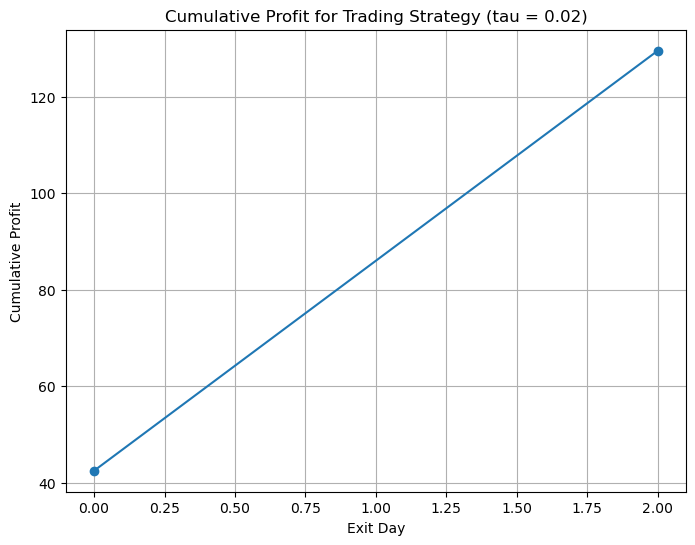

In [ ]:
import pandas as pd
import numpy as np
import math
from scipy import stats, optimize
import matplotlib.pyplot as plt

# === Utility Functions ===

def bs_call_price(S, K, T, sigma, r=0.0):
    """
    Black-Scholes call option price (assumes zero risk-free rate).
    """
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

def implied_vol(S, K, T, market_price, r=0.0):
    """
    Finds the implied volatility by solving the Black-Scholes equation.
    """
    def f(sigma):
        return bs_call_price(S, K, T, sigma, r) - market_price
    try:
        vol = optimize.brentq(f, 1e-6, 5.0)
    except Exception:
        vol = np.nan
    return vol

def bs_vega(S, K, T, sigma, r=0.0):
    """
    Computes the Black-Scholes vega.
    """
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return S * np.sqrt(T) * stats.norm.pdf(d1)

# === Data Loading and Preparation ===

# List of CSV files (adjust file paths as necessary)
files = [
    "prices_round_3_day_0.csv",
    "prices_round_3_day_1.csv",
    "prices_round_3_day_2.csv"
]

# Load CSV files using ';' as delimiter and tag each with a day indicator.
dfs = []
for i, file in enumerate(files):
    df = pd.read_csv(file, delimiter=';')
    df["day"] = i
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

# --- Extract Underlying Price ---
# Rows where product == "VOLCANIC_ROCK" contain the underlying price (as mid_price).
underlying_df = data[data["product"] == "VOLCANIC_ROCK"][["day", "mid_price"]].rename(columns={"mid_price": "S"})
underlying_df = underlying_df.drop_duplicates(subset="day")

# --- Filter Voucher Data ---
# Voucher rows: products starting with "VOLCANIC_ROCK_VOUCHER"
voucher_data = data[data["product"].str.startswith("VOLCANIC_ROCK_VOUCHER")].copy()
voucher_data = voucher_data.merge(underlying_df, on="day", how="left")

# Define voucher strike prices (adjust if needed)
voucher_strikes = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500
}

# Assume Time-To-Expiry (TTE) is 5 days.
TTE = 5.0

# === Compute Metrics for Each Voucher ===
results = []
for idx, row in voucher_data.iterrows():
    product = row["product"]
    if product not in voucher_strikes:
        continue
    K = voucher_strikes[product]
    S = row["S"]               # underlying price (S) from merged data
    price = row["mid_price"]   # observed voucher price
    timestamp = row["timestamp"]
    day = row["day"]
    
    # Normalized moneyness: m = ln(K/S)/sqrt(TTE)
    m = np.log(K / S) / np.sqrt(TTE)
    
    # Compute implied volatility using the Black-Scholes inversion.
    iv = implied_vol(S, K, TTE, price, r=0)
    if np.isnan(iv):
        continue
    # Compute vega (for reference)
    vega = bs_vega(S, K, TTE, iv, r=0)
    
    results.append({
        "timestamp": timestamp,
        "day": day,
        "voucher": product,
        "K": K,
        "S": S,
        "price": price,
        "m": m,
        "iv": iv,
        "vega": vega
    })

res_df = pd.DataFrame(results)

# === Fit a Quadratic (Parabolic) Curve Per Day ===
# We assume the relationship: iv(m) = c2*m^2 + c1*m + c0.
# (The base IV is c0 = fitted iv at m=0.)
fitted_results = []
for day, day_df in res_df.groupby("day"):
    coeffs = np.polyfit(day_df["m"], day_df["iv"], 2)  # Coefficients: [c2, c1, c0]
    for idx, row in day_df.iterrows():
        m_val = row["m"]
        fitted_iv = coeffs[0] * (m_val**2) + coeffs[1] * m_val + coeffs[2]
        residual = row["iv"] - fitted_iv
        fitted_results.append({
            **row,
            "fitted_iv": fitted_iv,
            "residual": residual,
            "c2": coeffs[0],
            "c1": coeffs[1],
            "c0": coeffs[2]  # Base IV (at m = 0)
        })

fitted_df = pd.DataFrame(fitted_results)

# === Trading Strategy Simulation Using Actual Prices ===
# Trading rule:
#  - If |residual| > threshold tau on day d, enter a trade for that voucher.
#  - For a positive residual, the voucher appears overpriced so we short: 
#         Profit per unit = entry mid_price - exit mid_price.
#  - For a negative residual, the voucher appears underpriced so we go long: 
#         Profit per unit = exit mid_price - entry mid_price.
#  - We simulate trades from day d (entry) to day d+1 (exit) and record the corresponding timestamps.
tau = 0.02  # threshold for signaling a trade (adjustable)
trades = []

# For each voucher, sort observations by day (or timestamp) and simulate the trade.
for voucher, voucher_df in fitted_df.groupby("voucher"):
    voucher_df = voucher_df.sort_values("day").reset_index(drop=True)
    for i in range(len(voucher_df) - 1):
        entry = voucher_df.iloc[i]
        exit_ = voucher_df.iloc[i+1]
        # Check if the mispricing signal is strong enough.
        if abs(entry["residual"]) > tau:
            entry_price = entry["price"]  # mid price on entry day
            exit_price = exit_["price"]     # mid price on exit day
            # Record the timestamps from the original data.
            entry_timestamp = entry["timestamp"]
            exit_timestamp = exit_["timestamp"]
            
            # For an overpriced voucher (positive residual) we short, so profit = entry - exit.
            # For an underpriced voucher (negative residual) we go long, so profit = exit - entry.
            if entry["residual"] > 0:
                trade_profit = entry_price - exit_price
                direction = "short"
            else:
                trade_profit = exit_price - entry_price
                direction = "long"
            
            trades.append({
                "voucher": voucher,
                "entry_day": entry["day"],
                "exit_day": exit_["day"],
                "entry_timestamp": entry_timestamp,
                "exit_timestamp": exit_timestamp,
                "entry_price": entry_price,
                "exit_price": exit_price,
                "residual": entry["residual"],
                "direction": direction,
                "profit": trade_profit
            })

trades_df = pd.DataFrame(trades)

if trades_df.empty:
    print("No trades were generated under the chosen threshold.")
else:
    total_profit = trades_df["profit"].sum()
    num_trades = len(trades_df)
    avg_profit = total_profit / num_trades if num_trades > 0 else 0.0
    print(f"Total Profit: {total_profit:.2f}")
    print(f"Number of Trades: {num_trades}")
    print(f"Average Profit per Trade: {avg_profit:.2f}")
    print(trades_df)

    # === Plot PNL for each Exit Timestamp ===
    # First, convert exit_timestamp to a numeric or datetime type if necessary.
    # Here we assume exit_timestamp is numeric; if it's a string, use pd.to_datetime().
    pnl_by_timestamp = trades_df.groupby("exit_timestamp")["profit"].sum().sort_index()
    cumulative_pnl = pnl_by_timestamp.cumsum()
    
    plt.figure(figsize=(10, 6))
    plt.plot(pnl_by_timestamp.index, pnl_by_timestamp.values, marker='o', linestyle='-', label="Trade PNL")
    plt.plot(cumulative_pnl.index, cumulative_pnl.values, marker='s', linestyle='-', color='red', label="Cumulative PNL")
    plt.xlabel("Exit Timestamp")
    plt.ylabel("Profit")
    plt.title(f"PNL by Exit Timestamp (tau = {tau})")
    plt.legend()
    plt.grid(True)
    plt.show()
